Aqui verificamos:
+ A quantidade de tokens que contém caracteres não comuns no português, no caso do Bertimbau;
+ A quantidade de tokens que o dataset assin2 gera nos modelos:
    + BERT Multilingual;
    + Bertimbau;
    + BERTugues.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import regex as re
from tqdm import tqdm
tqdm.pandas()

from datasets import Dataset

In [3]:
from transformers import AutoTokenizer

tokenizer_bert = AutoTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenizer_timbau = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)
tokenizer = AutoTokenizer.from_pretrained('ricardoz/BERTugues-base-portuguese-cased', do_lower_case=False)

## Vamos contar os caracteres de linguagem oriental

In [4]:
regex_find = re.compile("[^"
    u"\U00000000-\U000000FF"
    u"\U00002000-\U0000206F"
    u"\U0001F446-\U0001F450"
    u"\U0001F600-\U0001F64F"
    "]+", re.UNICODE)

# https://symbl.cc/en/unicode/blocks/

In [5]:
vocab_bau = [x for x in tokenizer_timbau.get_vocab().keys() if bool(regex_find.search(x))]

In [6]:
len(vocab_bau)

7438

In [7]:
vocab_bau[:10]

['##ン', '##뼥', '##抹', '##上', '##홪', '##趣', '##達', '##쎹', '##飲', '##反']

## Vamos comparar a qualidade da tokenização entre os tokenizadores

In [8]:
from datasets import load_dataset

In [9]:
dataset = load_dataset("assin2")

Found cached dataset assin2 (C:/Users/ricar/.cache/huggingface/datasets/assin2/default/1.0.0/8467f7acbda82f62ab960ca869dc1e96350e0e103a1ef7eaa43bbee530b80061)


  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
def trat(x):
    return {"frase":x["premise"] + " " + x["hypothesis"]}

In [11]:
dataset = dataset.map(trat)

Loading cached processed dataset at C:\Users\ricar\.cache\huggingface\datasets\assin2\default\1.0.0\8467f7acbda82f62ab960ca869dc1e96350e0e103a1ef7eaa43bbee530b80061\cache-d9bb726c588818c0.arrow
Loading cached processed dataset at C:\Users\ricar\.cache\huggingface\datasets\assin2\default\1.0.0\8467f7acbda82f62ab960ca869dc1e96350e0e103a1ef7eaa43bbee530b80061\cache-9f8651ba8b9e4a27.arrow
Loading cached processed dataset at C:\Users\ricar\.cache\huggingface\datasets\assin2\default\1.0.0\8467f7acbda82f62ab960ca869dc1e96350e0e103a1ef7eaa43bbee530b80061\cache-d82fc31dd5f8221f.arrow


In [12]:
frases = []

for k in dataset.keys():
    frases.extend(dataset[k]['frase'])

In [13]:
df = pd.DataFrame(frases, columns = ["frase"])

In [14]:
df["tokens_timbau"] = df.frase.progress_apply(tokenizer_timbau.tokenize)
df["tokens_bert"] = df.frase.progress_apply(tokenizer_bert.tokenize)
df["tokens_gues"] = df.frase.progress_apply(tokenizer.tokenize)

100%|███████████████████████████████████████████████████████████████████████████| 9448/9448 [00:00<00:00, 16995.07it/s]


In [15]:
df["len_tokens_timbau"] = df.tokens_timbau.progress_apply(len)
df["len_tokens_bert"] = df.tokens_bert.progress_apply(len)
df["len_tokens_gues"] = df.tokens_gues.progress_apply(len)

100%|█████████████████████████████████████████████████████████████████████████| 9448/9448 [00:00<00:00, 1889016.31it/s]


In [16]:
def count_nao_inicio(x):
    return len([a for a in x if a.startswith("##")])

In [17]:
df["len_nao_inicio_timbau"] = df.tokens_timbau.progress_apply(count_nao_inicio)
df["len_nao_inicio_bert"] = df.tokens_bert.progress_apply(count_nao_inicio)
df["len_nao_inicio_gues"] = df.tokens_gues.progress_apply(count_nao_inicio)

100%|██████████████████████████████████████████████████████████████████████████| 9448/9448 [00:00<00:00, 519306.82it/s]


In [18]:
df["len_nao_inicio_timbau_trunk"] = df.len_nao_inicio_timbau.progress_apply(lambda x: np.minimum(x,15))
df["len_nao_inicio_bert_trunk"] = df.len_nao_inicio_bert.progress_apply(lambda x: np.minimum(x,15))
df["len_nao_inicio_gues_trunk"] = df.len_nao_inicio_gues.progress_apply(lambda x: np.minimum(x,15))

100%|██████████████████████████████████████████████████████████████████████████| 9448/9448 [00:00<00:00, 243079.45it/s]


## Vamos comparar agora

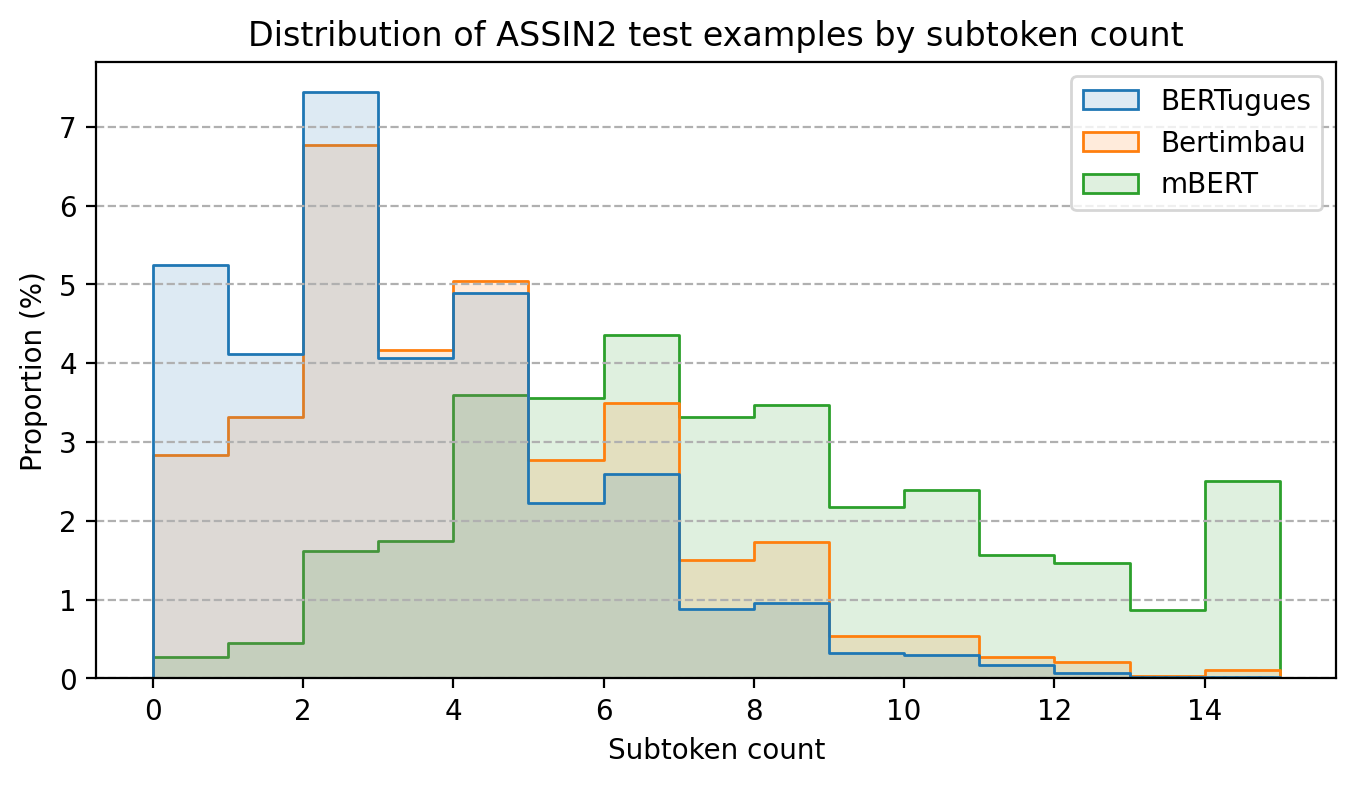

In [29]:
plt.figure(figsize=(8,4), dpi = 200)
sns.histplot(data=df[["len_nao_inicio_gues_trunk",
                      "len_nao_inicio_timbau_trunk",
                      "len_nao_inicio_bert_trunk"]].rename(columns={
"len_nao_inicio_gues_trunk":"BERTugues",
"len_nao_inicio_timbau_trunk":"Bertimbau",
"len_nao_inicio_bert_trunk":"mBERT"
}),
             stat="percent", binwidth=1, element="step", alpha = 0.15).set(
                title = "Distribution of ASSIN2 test examples by subtoken count")

plt.xlabel('Subtoken count')
plt.ylabel('Proportion (%)')
ax = plt.gca()
ax.grid(which='major', axis='y', linestyle='--')
plt.show()

In [28]:
print(f"""Caracteres não inicio no:
mBERT: {df["len_nao_inicio_bert"].mean()}
Bertimbau: {df["len_nao_inicio_timbau"].mean()}
BERTugues: {df["len_nao_inicio_gues"].mean()}
""")

Caracteres não inicio no:
mBERT: 7.44612616426757
Bertimbau: 3.7923370025402203
BERTugues: 3.0156646909398814

